# Adaptive Line Enhancer (ALE)

In this tutorial it is explained how to use Padasip adaptive filters as an adaptive line enhancer. Adaptive line enhancer is basically a filter, that is predicting a periodic noise in the observation. The input of the adaptive filter is delayed history of observed/target data. Output of the filter is the harmonic noise (it is the part of the data that can predicted), while the filter error is the target signal - original information in data.

## Full working example

In [1]:
import matplotlib.pylab as plt
import padasip as pa
import numpy as np
from scipy.io import wavfile
from scipy.fftpack import fft
from IPython.display import Audio
import IPython

def zs(a):
    """ 1d data z-score """
    a -= a.mean()
    return a / a.std()


# constants
FILENAME = "Frase_de_Neil_Armstrong.wav"
SAMPLERATE = 44100
n = 300 # filter size
D = 200 # signal delay


# open and process source data
fs, data = wavfile.read(FILENAME)
y = data[:,0].copy()
y = y.astype("float64")
y = zs(y) / 10
N = len(y)

# contaminated with noise
q = np.sin(2*np.pi*1000/99*np.arange(N) + 10.1 * np.sin(2*np.pi/110*np.arange(N)))
d = y + q

# prepare data for simulation
x = pa.input_from_history(d, n)[:-D]
d = d[n+D-1:]
y = y[n+D-1:]
q = q[n+D-1:]

# create filter and filter
f = pa.filters.FilterNLMS(n=n, mu=0.01, w="zeros")
yp, e, w = f.run(d, x)

# display sound players for human validation
print("Original record:")
IPython.display.display(Audio(y, rate=SAMPLERATE))

print("Distorted record:")
IPython.display.display(Audio(d, rate=SAMPLERATE))

print("Enhanced record")
IPython.display.display(Audio(e, rate=SAMPLERATE))

Original record:


Distorted record:


Enhanced record


In case the sounds are not playable in notebook directly, you can download the files from:

* [Original record (orig.wav)](https://github.com/matousc89/Python-Adaptive-Signal-Processing-Handbook/raw/master/notebooks/ALE/orig.wav)

* [Distorted record (distorted.wav)](https://github.com/matousc89/Python-Adaptive-Signal-Processing-Handbook/raw/master/notebooks/ALE/distorted.wav)

* [Enhanced (filtered) record (enhanced.wav)](https://github.com/matousc89/Python-Adaptive-Signal-Processing-Handbook/raw/master/notebooks/ALE/enhanced.wav)

Or also you can save new version of records on your computer as follows:

In [2]:
# saving
wavfile.write("orig.wav", 44100, d)
wavfile.write("distorted.wav", 44100, d)
wavfile.write("enhanced.wav", 44100, e)

## Source data import and preparation
In this tutorial, the sound is handled as a single numpy array. After it is loaded via *scipi.io.wavfile.read*, it is futher processed. First, we get rid of one of the channels (we need only one in this tutorial, and we expect they are both the same). After that we make the sound reasonably scaled (by z-scoring and dividing by 10).

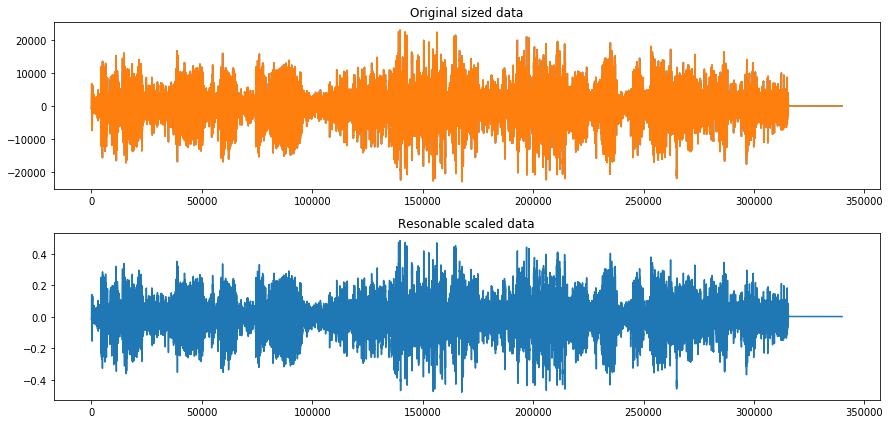

In [3]:
fs, data = wavfile.read(FILENAME)
y = data[:,0].copy()
y = y.astype("float64")
y = zs(y) / 10

plt.figure(figsize=(12.5,6))

plt.subplot(211)
plt.plot(data)
plt.title("Original sized data")

plt.subplot(212)
plt.plot(y)
plt.title("Resonable scaled data")

plt.tight_layout()
plt.show()

## Data contamination

Using a sinus-like periodic signal would be too easy to filter via notch filter (if the frequency si known). Because of that, we create slightly more challanging signal by modulation harmonic wave by another harmonic wave.

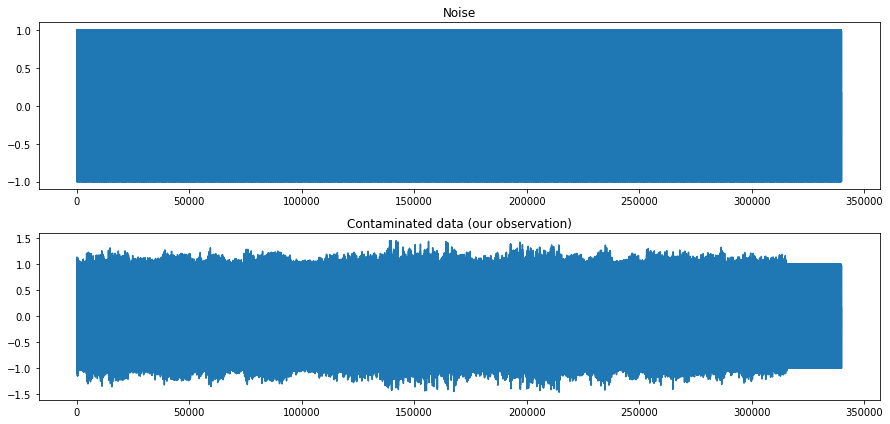

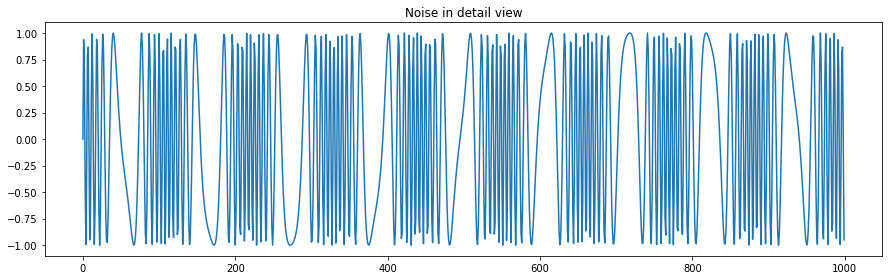

In [4]:
q = np.sin(2*np.pi*1000/99*np.arange(N) + 10.1 * np.sin(2*np.pi/110*np.arange(N)))
d = y + q

plt.figure(figsize=(12.5,6))

plt.subplot(211)
plt.plot(q)
plt.title("Noise")

plt.subplot(212)
plt.plot(d)
plt.title("Contaminated data (our observation)")

plt.tight_layout()
plt.show()


scope = 1000

plt.figure(figsize=(12.5,4))

plt.plot(q[:scope])
plt.title("Noise in detail view")

plt.tight_layout()
plt.show()

## More on problem statement
To understand why the chirp like harmonic signal can be so tricky, see the FFT image of chirp like noise.

In [5]:
def fft_helper(qf, label=""):
    """ FFT helper function """
    Nf = len(qf)
    T = 1.0 / 44100
    yf = fft(qf)
    xf = np.linspace(0.0, 1.0/(2.0*T), Nf//2)

    plt.figure(figsize=(12.5,6))

    plt.subplot(211)
    plt.plot(qf)
    plt.title(label)
    plt.ylabel("Amplitude [-]")
    plt.xlabel("Sample index [sample]")

    plt.subplot(212)
    plt.plot(xf, 2.0/Nf * np.abs(yf[0:Nf//2]))
    plt.title("Frequency spectrum")
    plt.ylabel("Power [-]")
    plt.xlabel("Freq [Hz]")

    plt.tight_layout()
    plt.show()    
    
Nf = 1000

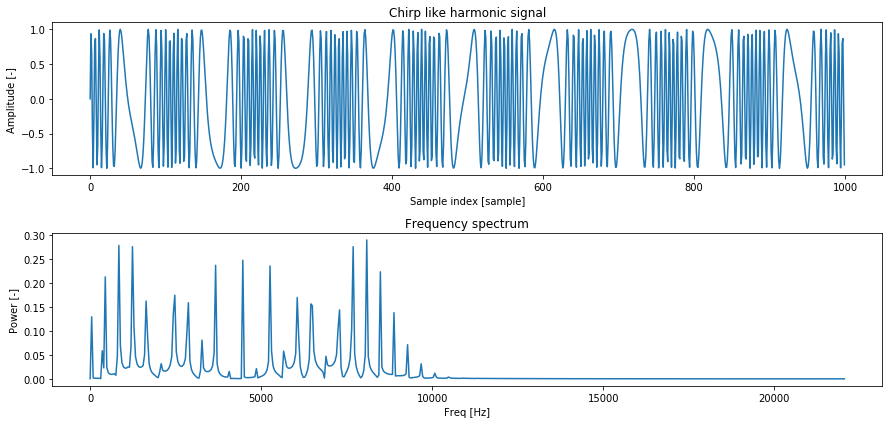

In [6]:
qf1 = np.sin(2*np.pi*1000/99*np.arange(Nf) + 10.1 * np.sin(2*np.pi/110*np.arange(Nf)))
fft_helper(qf1, label="Chirp like harmonic signal")

Next example is sinus like harmonic signal - this one is quite easy to filter in frequency spectrum - it is only one peak.

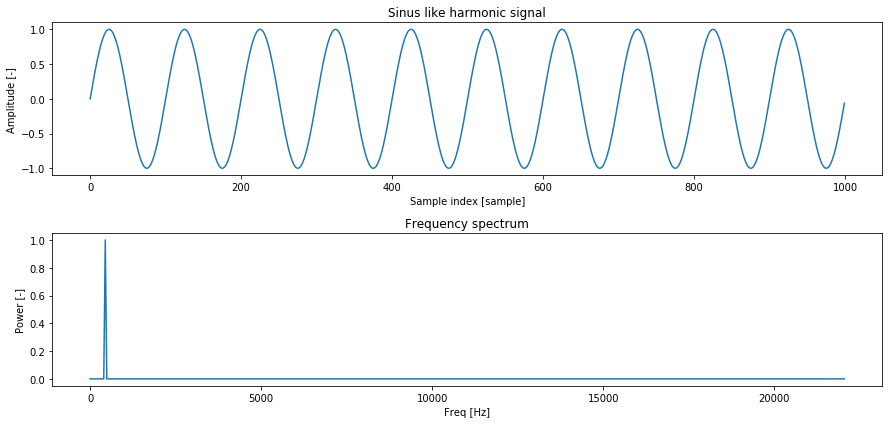

In [7]:
qf2 = np.sin(2*np.pi*0.01*np.arange(Nf))
fft_helper(qf2, label="Sinus like harmonic signal")

The FFT image of a speech record without the periodic noise follows.

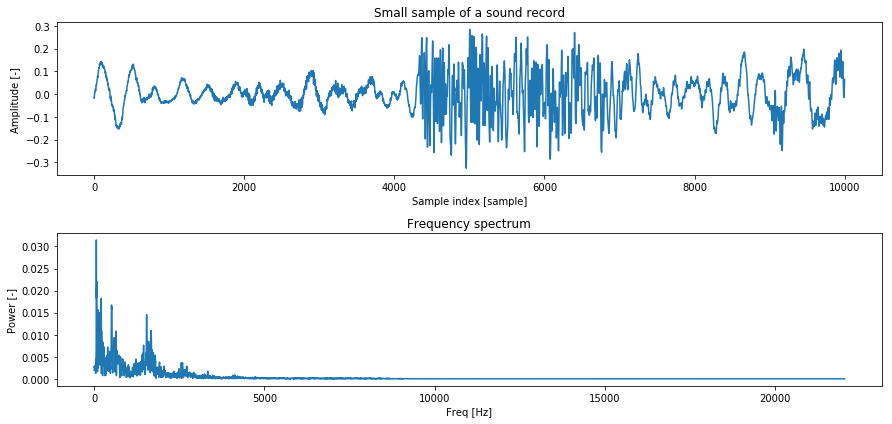

In [8]:
fft_helper(y[:10000], label="Small sample of a sound record")

And the final example - speech record contaminated with chirp like signal.

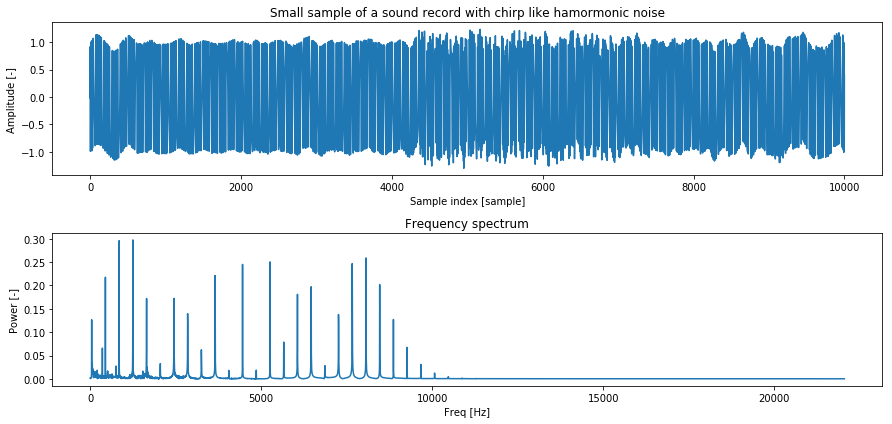

In [9]:
Nf = 10000
qf1l = np.sin(2*np.pi*1000/99*np.arange(Nf) + 10.1 * np.sin(2*np.pi/110*np.arange(Nf)))
fft_helper(y[:Nf] + qf1l, label="Small sample of a sound record with chirp like hamormonic noise")

## Adaptive filter preparation and filtering
First we need to reshape the data for adaptive filter - every input vector (row in `x`) should be a history of delayed observations (`d`). All other signals are croped according to match the size of matrix `x`.

In [10]:
x = pa.input_from_history(d, n)[:-D]
d = d[n+D-1:]
y = y[n+D-1:]
q = q[n+D-1:]

The filter we use is NLMS adaptive filter implementation (`padasip.filters.FilterNLMS`) with filter lenght `n`, learning rate `mu` and zero default weights.

In [11]:
f = pa.filters.FilterNLMS(n=n, mu=0.01, w="zeros")
yp, e, w = f.run(d, x)

The error `e`, is our desired output. It is the difference between observation and noise - the original signal.

## Method tuning and conslusion
The ALE can work quite well to filter a peridic noises. However this is limited by filter ability to learn the periodicty in the noise. To tune the method for various cases, you can adjust:

- filter lenght
- filter delay
- filter learning rate 

Those three parameters are related. Togehter they define what are the frequencies that the filter is able to track.
